### Instead of hardcoded thresholds, use a more flexible approach that adapts to the data and model performance:
* Machine Learning Techniques:
    - Employ techniques like hyperparameter tuning and feature engineering to improve model performance and reduce error.
* Statistical Hypothesis Testing:
    - Use hypothesis testing to compare the performance of your model to a baseline or a benchmark model.
* Percentile-Based Thresholds:
    - Calculate percentiles of the error distribution to set dynamic thresholds. For example, you might define "excellent" as the top 10% of models in terms of MSE.

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit

In [3]:
st = st.Stocks()

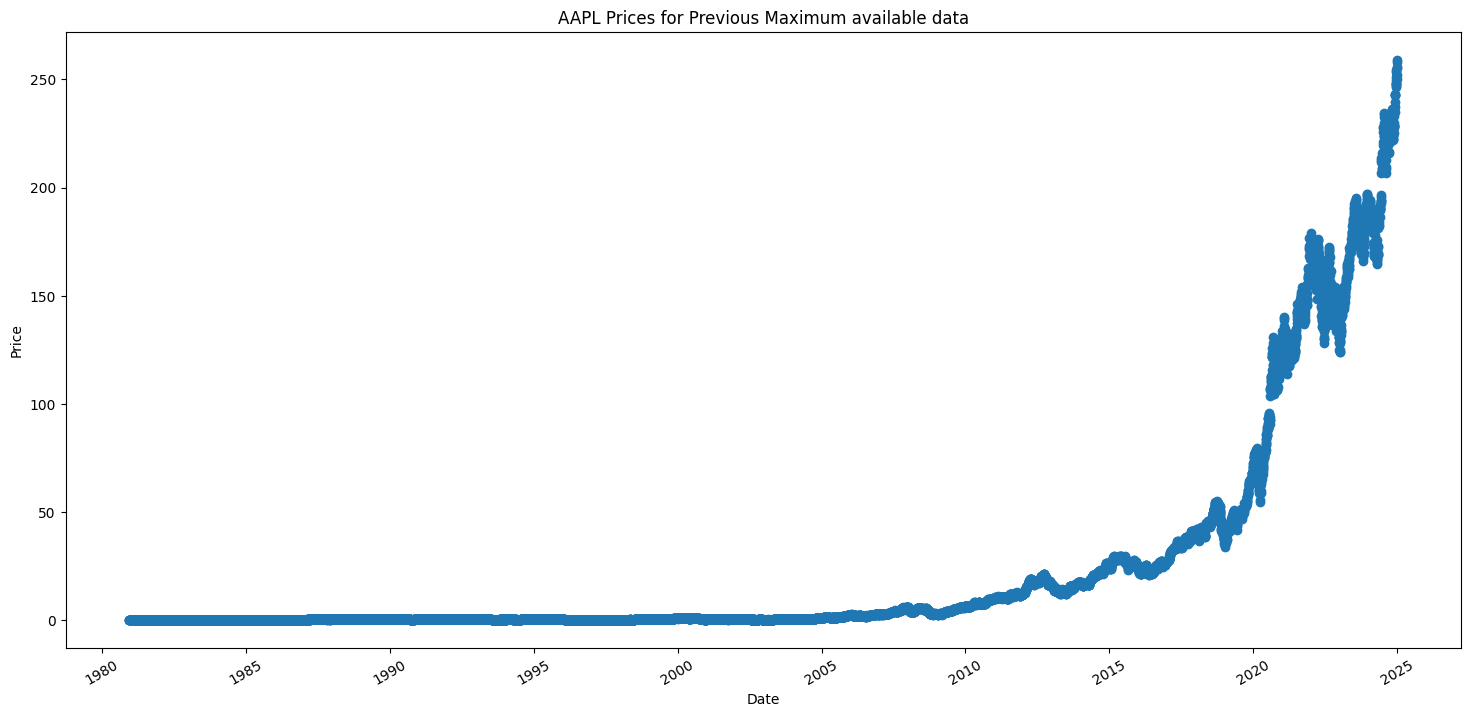

Closing price as of 2024-12-31: $250.42
The percentage change over previous Maximum available data is 253273%
Dividends total $8.77
Stock Splits total $17.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('aapl')

In [5]:
df.head()

Date      Open      High       Low     Close  \
0 1980-12-12 00:00:00-05:00  0.098834  0.099264  0.098834  0.098834   
1 1980-12-15 00:00:00-05:00  0.094108  0.094108  0.093678  0.093678   
2 1980-12-16 00:00:00-05:00  0.087232  0.087232  0.086802  0.086802   
3 1980-12-17 00:00:00-05:00  0.088951  0.089381  0.088951  0.088951   
4 1980-12-18 00:00:00-05:00  0.091530  0.091959  0.091530  0.091530   

      Volume  Dividends  Stock Splits  
0  469033600        0.0           0.0  
1  175884800        0.0           0.0  
2  105728000        0.0           0.0  
3   86441600        0.0           0.0  
4   73449600        0.0           0.0

In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
df_train = df[['Date' ,'Close']]
df_train = df_train.rename(columns={'Date': 'ds', 'Close': 'y'})

In [8]:
period = 365

In [9]:
%%time

from prophet import Prophet

m = Prophet()
m.fit(df_train)
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

15:44:43 - cmdstanpy - INFO - Chain [1] start processing
15:44:46 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 978 ms, sys: 141 ms, total: 1.12 s
Wall time: 5.11 s


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(df_train, forecast):
    # Extract actual and predicted values
    y_true = df_train['y'][-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [11]:
get_model_accuracy(df_train, forecast)

Mean Absolute Error  Mean Absolute Percentage Error  Mean Squared Error  \
0            23.540603                         0.12848          800.188889   

   Root Mean Squared Error  
0                 28.28761

In [12]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### Grid Search

In [13]:
%%time
# Define hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10]
}

# Perform grid search
best_params = None
best_rmse = float('inf')

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        # Create and fit the model
        m = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        m.fit(df_train)

        # Make predictions
        future = m.make_future_dataframe(periods=period) 
        forecast = m.predict(future)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(df_train['y'][-period:], forecast['yhat'][-period:]))

        # Update best parameters if necessary
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
            }

15:44:48 - cmdstanpy - INFO - Chain [1] start processing
15:44:49 - cmdstanpy - INFO - Chain [1] done processing
15:44:50 - cmdstanpy - INFO - Chain [1] start processing
15:44:52 - cmdstanpy - INFO - Chain [1] done processing
15:44:54 - cmdstanpy - INFO - Chain [1] start processing
15:44:55 - cmdstanpy - INFO - Chain [1] done processing
15:44:56 - cmdstanpy - INFO - Chain [1] start processing
15:44:57 - cmdstanpy - INFO - Chain [1] done processing
15:44:58 - cmdstanpy - INFO - Chain [1] start processing
15:45:00 - cmdstanpy - INFO - Chain [1] done processing
15:45:01 - cmdstanpy - INFO - Chain [1] start processing
15:45:03 - cmdstanpy - INFO - Chain [1] done processing
15:45:05 - cmdstanpy - INFO - Chain [1] start processing
15:45:07 - cmdstanpy - INFO - Chain [1] done processing
15:45:08 - cmdstanpy - INFO - Chain [1] start processing
15:45:10 - cmdstanpy - INFO - Chain [1] done processing
15:45:11 - cmdstanpy - INFO - Chain [1] start processing
15:45:15 - cmdstanpy - INFO - Chain [1]

CPU times: user 15.3 s, sys: 2.37 s, total: 17.7 s
Wall time: 55.1 s


In [14]:
print(f"Best parameters: {best_params}") 
print(f"Best RMSE: {best_rmse}")

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}
Best RMSE: 21.0164180682802


In [15]:
def implement_tuning():
    m = Prophet(
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale']
        )
    m.fit(df_train)

    # Make predictions
    future = m.make_future_dataframe(periods=period) 
    forecast = m.predict(future)

    return forecast

In [16]:
%%time
forecast = implement_tuning()

15:45:44 - cmdstanpy - INFO - Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 941 ms, sys: 145 ms, total: 1.09 s
Wall time: 1.75 s


In [17]:
get_model_accuracy(df_train, forecast)

Mean Absolute Error  Mean Absolute Percentage Error  Mean Squared Error  \
0              18.4842                        0.096651          441.689828   

   Root Mean Squared Error  
0                21.016418

In [18]:
# visualize

# Plot Forecast
fig1 = plot_plotly(m, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### Cross Validation

- w/o tuning

In [19]:
%%time

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

m = Prophet()
m.fit(df_train)

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

df_p = performance_metrics(df_cv)

15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/84 [00:00<?, ?it/s]

15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1]

CPU times: user 17.4 s, sys: 1.82 s, total: 19.2 s
Wall time: 1min 45s


In [20]:
print(df_p.mean())

horizon     201 days 00:00:00
mse                215.442094
rmse                14.555055
mae                  5.554213
mape                  0.42174
mdape                0.311013
smape                0.424632
coverage             0.179181
dtype: object


- with tuning

In [21]:
%%time
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define hyperparameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
    'seasonality_prior_scale': [0.1, 1, 10] 
}

best_params = None
best_score = float('inf') 

for seasonality_mode in param_grid['seasonality_mode']:
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            # Create and fit the model
            m = Prophet(
                seasonality_mode=seasonality_mode,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale
            )
        m.fit(df_train)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days') 
        df_p = performance_metrics(df_cv)
        score = df_p['rmse'].mean() 

        if score < best_score:
            best_score = score
            best_params = {
                'seasonality_mode': seasonality_mode,
                'changepoint_prior_scale': changepoint_prior_scale,
                'seasonality_prior_scale': seasonality_prior_scale
                        }

15:47:31 - cmdstanpy - INFO - Chain [1] start processing
15:47:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/84 [00:00<?, ?it/s]

15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:33 - cmdstanpy - INFO - Chain [1] done processing
15:47:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:47:33 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:34 - cmdstanpy - INFO - Chain [1] start processing
15:47:34 - cmdstanpy - INFO - Chain [1] done processing
15:47:35 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/84 [00:00<?, ?it/s]

15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:37 - cmdstanpy - INFO - Chain [1] done processing
15:48:37 - cmdstanpy - INFO - Chain [1] start processing
15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:38 - cmdstanpy - INFO - Chain [1] start processing
15:48:38 - cmdstanpy - INFO - Chain [1] done processing
15:48:38 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:39 - cmdstanpy - INFO - Chain [1] done processing
15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:48:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:11 - cmdstanpy - INFO - Chain [1] done processing
15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:12 - cmdstanpy - INFO - Chain [1] done processing
15:51:12 - cmdstanpy - INFO - Chain [1] start processing
15:51:13 - cmdstanpy - INFO - Chain [1] done processing
15:51:13 - cmdstanpy - INFO - Chain [1] start processing
15:51:13 - cmdstanpy - INFO - Chain [1] done processing
15:51:13 - cmdstanpy - INFO - Chain [1] start processing
15:51:14 - cmdstanpy - INFO - Chain [1] done processing
15:51:14 - cmdstanpy - INFO - Chain [1] start processing
15:51:15 - cmdstanpy - INFO - Chain [1] done processing
15:51:16 - cmdstanpy - INFO - Chain [1] start processing
15:51:17 - cmdstanpy - INFO - Chain [1] done processing
15:51:17 - cmdstanpy - INFO - Chain [1] start processing
15:51:18 - cmdstanpy - INFO - Chain [1] done processing
15:51:18 - cmdstanpy - INFO - Chain [1] start processing
15:51:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

15:55:12 - cmdstanpy - INFO - Chain [1] start processing
15:55:12 - cmdstanpy - INFO - Chain [1] done processing
15:55:12 - cmdstanpy - INFO - Chain [1] start processing
15:55:13 - cmdstanpy - INFO - Chain [1] done processing
15:55:13 - cmdstanpy - INFO - Chain [1] start processing
15:55:14 - cmdstanpy - INFO - Chain [1] done processing
15:55:14 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:15 - cmdstanpy - INFO - Chain [1] start processing
15:55:16 - cmdstanpy - INFO - Chain [1] done processing
15:55:16 - cmdstanpy - INFO - Chain [1] start processing
15:55:17 - cmdstanpy - INFO - Chain [1] done processing
15:55:17 - cmdstanpy - INFO - Chain [1] start processing
15:55:18 - cmdstanpy - INFO - Chain [1] done processing
15:55:18 - cmdstanpy - INFO - Chain [1] start processing
15:55:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

15:58:08 - cmdstanpy - INFO - Chain [1] start processing
15:58:08 - cmdstanpy - INFO - Chain [1] done processing
15:58:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:58:08 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing
15:58:09 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing
15:58:09 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing
15:58:09 - cmdstanpy - INFO - Chain [1] start processing
15:58:09 - cmdstanpy - INFO - Chain [1] done processing
15:58:10 - cmdstanpy - INFO - Chain [1] start processing
15:58:10 - cmdstanpy - INFO - Chain [1] done processing
15:58:10 - cmdstanpy - INFO - Chain [1] start processing
15:58:10 - cmdstanpy - INFO - Chain [1] done processing
15:58:10 - cmdstanpy - INFO - Chain [1] start process

  0%|          | 0/84 [00:00<?, ?it/s]

15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:54 - cmdstanpy - INFO - Chain [1] done processing
15:58:55 - cmdstanpy - INFO - Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:54 - cmdstanpy - INFO - Chain [1] done processing
15:59:54 - cmdstanpy - INFO - Chain [1] start processing
15:59:54 - cmdstanpy - INFO - Chain [1] done processing
15:59:54 - cmdstanpy - INFO - Chain [1] start processing
15:59:54 - cmdstanpy - INFO - Chain [1] done processing
15:59:54 - cmdstanpy - INFO - Chain [1] start processing
15:59:55 - cmdstanpy - INFO - Chain [1] done processing
15:59:55 - cmdstanpy - INFO - Chain [1] start processing
15:59:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/84 [00:00<?, ?it/s]

16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:55 - cmdstanpy - INFO - Chain [1] done processing
16:01:55 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:56 - cmdstanpy - INFO - Chain [1] done processing
16:01:56 - cmdstanpy - INFO - Chain [1] start processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing
16:01:57 - cmdstanpy - INFO - Chain [1] start processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing
16:01:57 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:58 - cmdstanpy - INFO - Chain [1] done processing
16:01:58 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1]

CPU times: user 2min 17s, sys: 13.2 s, total: 2min 30s
Wall time: 16min 40s


In [22]:
# Train the final model with the best hyperparameters
final_model = Prophet(**best_params)
final_model.fit(df_train)

16:04:12 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
best_params

{'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 10}

In [24]:
%%time
df_cv = cross_validation(final_model, initial='730 days', period='180 days', horizon = '365 days')

df_p = performance_metrics(df_cv)

  0%|          | 0/84 [00:00<?, ?it/s]

16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing
16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing
16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing
16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing
16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:18 - cmdstanpy - INFO - Chain [1] done processing
16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:18 - cmdstanpy - INFO - Chain [1] done processing
16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:19 - cmdstanpy - INFO - Chain [1] done processing
16:04:19 - cmdstanpy - INFO - Chain [1] start processing
16:04:19 - cmdstanpy - INFO - Chain [1]

CPU times: user 17.2 s, sys: 1.76 s, total: 19 s
Wall time: 2min 20s


In [25]:
print(df_p.mean())

horizon     201 days 00:00:00
mse                210.280098
rmse                14.378094
mae                  5.484445
mape                   0.4156
mdape                0.300718
smape                0.418962
coverage             0.273217
dtype: object


In [26]:
%%time
from prophet import Prophet


future = final_model.make_future_dataframe(periods=period)
forecast = final_model.predict(future)

CPU times: user 668 ms, sys: 150 ms, total: 818 ms
Wall time: 918 ms


In [27]:
get_model_accuracy(df_train, forecast)

Mean Absolute Error  Mean Absolute Percentage Error  Mean Squared Error  \
0            23.917686                         0.13056          823.722852   

   Root Mean Squared Error  
0                28.700572